# APTOS  2019 Blindness Detection

Doing this as my first attempt of learning fastai  http://www.fast.ai


Thanks To ilovescience https://www.kaggle.com/tanlikesmath/intro-aptos-diabetic-retinopathy-eda-starter

@TODO
    Add more markdown / comments / links

## Setup (Download of kaggle dataset required. )

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
os.listdir('./')

['dataBunch',
 '.git',
 'sample_submission.csv',
 'README.md',
 'aptos.ipynb',
 'test.csv',
 'train_images',
 'train.csv',
 'models',
 'test_images',
 '.gitignore',
 '.ipynb_checkpoints']

In [4]:
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cudnn is enabled: True


In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

### Load data

In [6]:
base_image_dir = os.path.basename('./')
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,diagnosis,path
0,2,train_images/a01c590c444f.png
1,1,train_images/22098b1fe461.png
2,0,train_images/83a63c4a3e4a.png
3,4,train_images/e821c1b6417a.png
4,0,train_images/bd06028eb7dd.png
5,3,train_images/6089fa333013.png
6,2,train_images/9b418ce42c13.png
7,0,train_images/c6a8f8f998a2.png
8,0,train_images/b72f59b85f7c.png
9,1,train_images/8bbd7835e9aa.png


There are 3662 images


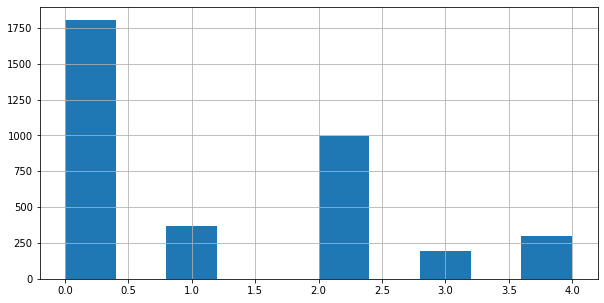

In [7]:
len_df = len(df)
print(f"There are {len_df} images")

df['diagnosis'].hist(figsize = (10, 5))


In [8]:
from PIL import Image

2416 1736


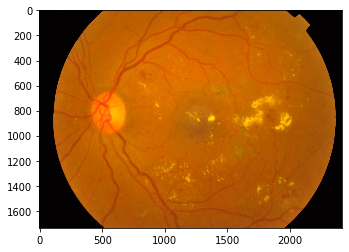

In [9]:
im = Image.open(df['path'][0])
width, height = im.size
print(width, height)
im.show()
plt.imshow(im)

In [10]:
doc(normalize)

In [11]:
sz = 224
bs = 64
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=180.,max_zoom=1.1,max_lighting=0.1,max_warp=0.,p_lighting=0.5)

In [12]:
src = (ImageList.from_df(df=df,path='./',cols='path')
           .split_by_rand_pct(0.2)
           .label_from_df(cols='diagnosis',label_cls=FloatList))

In [13]:
data = (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros')
       .databunch(bs=bs,num_workers=4)
       .normalize(imagenet_stats)
       )

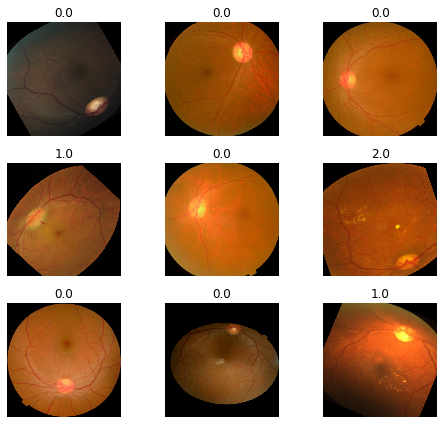

In [14]:
data.show_batch(rows=3, figsize=(7,6))


In [ ]:
# data.save('aptos-databunch')

### Training

Add scoring method

In [15]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')

In [16]:
learn = cnn_learner(data, base_arch=models.resnet50, metrics = [quadratic_kappa])


In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


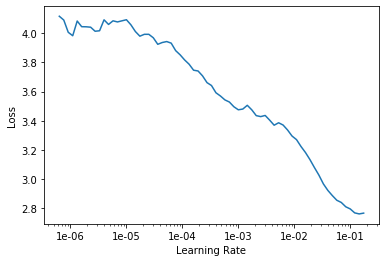

In [19]:
learn.recorder.plot() # Shows that a good max lr is 1e-2

In [17]:
learn.fit_one_cycle(4,max_lr = 1e-2)

epoch,train_loss,valid_loss,quadratic_kappa,time
0,1.754070,0.630955,0.758572,04:22
1,0.930338,0.321989,0.859436,04:15
2,0.607422,0.325581,0.874730,04:15
3,0.473973,0.298316,0.885822,04:14


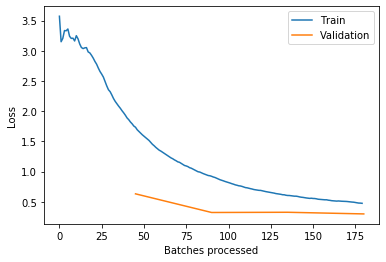

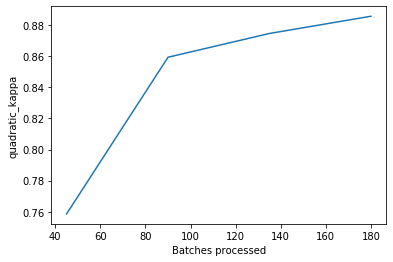

In [18]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [19]:
learn.save('stage-1-pretune')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


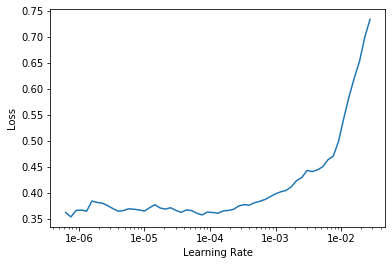

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(6,max_lr=slice(3e-6,1e-3))

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.378589,0.292079,0.889073,04:15
1,0.378433,0.276241,0.897734,04:14
2,0.360850,0.294515,0.879338,04:15
3,0.355212,0.280953,0.888676,04:20
4,0.305563,0.259335,0.892159,04:17
5,0.290525,0.263992,0.895131,04:16


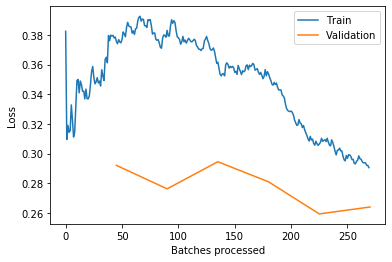

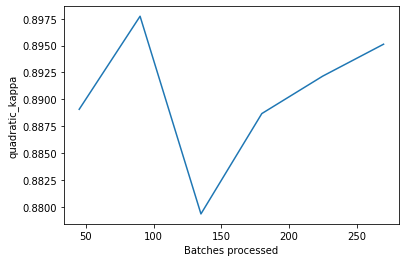

In [22]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [23]:
learn.export()
learn.save('stage-2-posttune')

#### Evaluation

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)


True

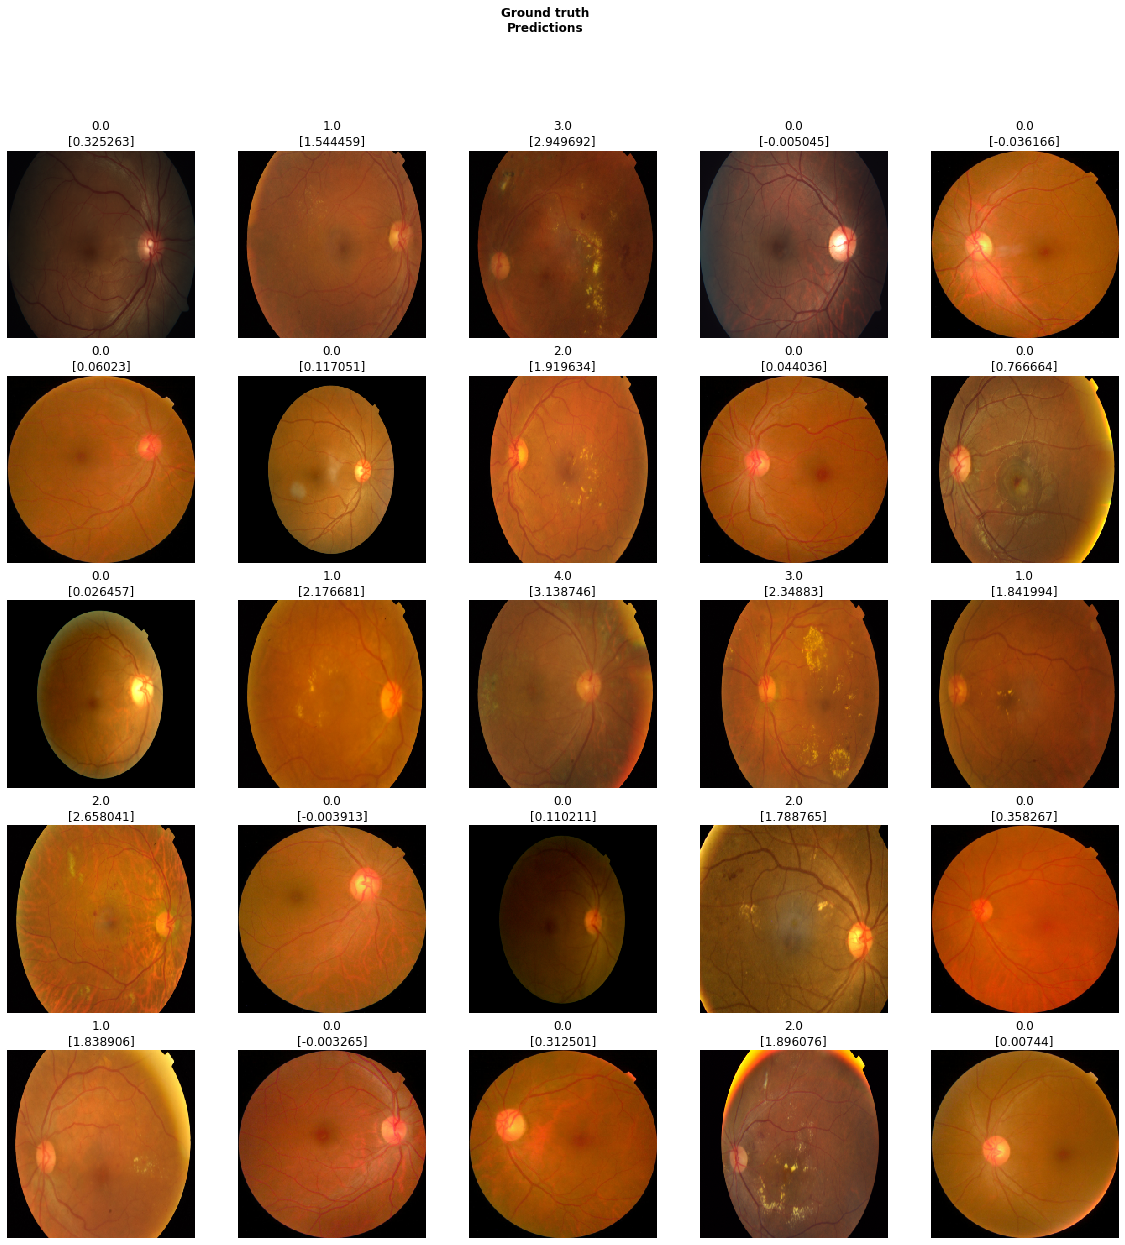

In [29]:
learn.show_results()

### Optimize Metric

In [30]:
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)


In [31]:
import numpy as np
import pandas as pd
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json

In [32]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [33]:
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])


0.9060106510292005


In [34]:
coefficients = optR.coefficients()
print(coefficients)

[0.555022 1.483425 2.328707 3.424011]


### TTA
Here ilovescience uses his own tta.
Will try default first

### Submission

In [36]:
sample_df = pd.read_csv('./sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [37]:
learn.data.add_test(ImageList.from_df(sample_df,'./',folder='test_images',suffix='.png'))


In [38]:
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [39]:
test_predictions = optR.predict(preds, coefficients)


In [40]:
sample_df.diagnosis = test_predictions.astype(int)
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2


In [41]:
sample_df.to_csv('submission.csv',index=False)

In [42]:
sample_df.tail()

,id_code,diagnosis
1923,ff2fd94448de,0
1924,ff4c945d9b17,3
1925,ff64897ac0d8,3
1926,ffa73465b705,3
1927,ffdc2152d455,1
